In [1]:
## Imports
import numpy as np
import torch
from tabulate import tabulate
from PIL import Image
import json
from utils.misc.misc import accuracy, accuracy_correct
from utils.scripts.algorithms_text_explanations import *
from utils.models.factory import create_model_and_transforms, get_tokenizer
from utils.misc.visualization import visualization_preprocess
from utils.models.prs_hook import hook_prs_logger
from utils.datasets_constants.imagenet_classes import imagenet_classes
from utils.datasets_constants.cifar_10_classes import cifar_10_classes
from utils.datasets_constants.cub_classes import cub_classes, waterbird_classes
import os
from utils.scripts.algorithms_text_explanations import svd_data_approx
from utils.datasets.dataset_helpers import dataset_to_dataloader
from torch.nn import functional as F
from utils.scripts.algorithms_text_explanations_funcs import *

/cluster/apps/vogtlab/users/vstrozzi/software/anaconda/envs/MT/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
## Parameters
device = 'cpu'
model_name = 'ViT-L-14' # 'ViT-H-14'
seed = 0
num_last_layers_ = 4
subset_dim = 10
tot_samples_per_class = 50
dataset_text_name = "top_1500_nouns_5_sentences_imagenet_clean"
datataset_image_name = "imagenet"
algorithm = "svd_data_approx"
path = './datasets/'
cache_dir = "../cache"

if model_name == "ViT-H-14":
    pretrained = "laion2B-s32B-b79K"
    precision = "fp32"
elif model_name == "ViT-L-14":
    pretrained = "laion2B-s32B-b82K"
    precision = "fp32"
elif model_name == "ViT-B-16":
    pretrained = "laion2B-s34B-b88K"
    precision = "fp32"
elif model_name == "ViT-B-32":
    pretrained = "laion2B-s34B-b79K"
    precision = "fp32"
elif model_name == "ViT-L-14-336":
    pretrained = "openai"
    precision = "fp16"

In [3]:
## Loading Model
model, _, preprocess = create_model_and_transforms(model_name, pretrained=pretrained, precision=precision, cache_dir=cache_dir)
model.to(device)
model.eval()
context_length = model.context_length
vocab_size = model.vocab_size
tokenizer = get_tokenizer(model_name)

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Context length:", context_length)
print("Vocab size:", vocab_size)
print("Len of res:", len(model.visual.transformer.resblocks))
prs = hook_prs_logger(model, device, spatial=False) # This attach hook to get the residual stream

Using local files
Model parameters: 427,616,513
Context length: 77
Vocab size: 49408
Len of res: 24


: 

In [80]:
## Run the chsen algorithm on a dataset to derive text explanations 
command = f"python -m utils.scripts.compute_text_explanations --device {device} --model {model_name} --algorithm {algorithm} --seed {seed} --text_per_princ_comp 20 --num_of_last_layers {num_last_layers_} --text_descriptions {dataset_text_name} --dataset {datataset_image_name}"
!{command}

Number of layers: 12
  0%|                                                     | 0/4 [00:00<?, ?it/s]
Layer [8], Head: 0

Layer [8], Head: 1

Layer [8], Head: 2

Layer [8], Head: 3

Layer [8], Head: 4

Layer [8], Head: 5

Layer [8], Head: 6

Layer [8], Head: 7

Layer [8], Head: 8

Layer [8], Head: 9

Layer [8], Head: 10

Layer [8], Head: 11
 25%|███████████▎                                 | 1/4 [00:07<00:21,  7.06s/it]
Layer [9], Head: 0

Layer [9], Head: 1

Layer [9], Head: 2

Layer [9], Head: 3

Layer [9], Head: 4

Layer [9], Head: 5

Layer [9], Head: 6

Layer [9], Head: 7

Layer [9], Head: 8

Layer [9], Head: 9

Layer [9], Head: 10

Layer [9], Head: 11
 50%|██████████████████████▌                      | 2/4 [00:13<00:13,  6.92s/it]
Layer [10], Head: 0

Layer [10], Head: 1

Layer [10], Head: 2

Layer [10], Head: 3

Layer [10], Head: 4

Layer [10], Head: 5

Layer [10], Head: 6

Layer [10], Head: 7

Layer [10], Head: 8

Layer [10], Head: 9

Layer [10], Head: 10

Layer [10], Head: 11
 

In [83]:
# Load the new created attention datasets
attention_dataset = f"output_dir/imagenet_completeness_{dataset_text_name}_{model_name}_algo_{algorithm}_seed_{seed}.jsonl"

# Load necessary data
attns_ = torch.tensor(np.load(f"output_dir/{datataset_image_name}_attn_{model_name}_seed_{seed}.npy", mmap_mode="r")).to(device, dtype=torch.float32)  # [b, l, h, d], attention values
mlps_ = torch.tensor(np.load(f"output_dir/{datataset_image_name}_mlp_{model_name}_seed_{seed}.npy", mmap_mode="r")).to(device, dtype=torch.float32)  # [b, l, h, d], mlp values
classifier_ = torch.tensor(np.load(f"output_dir/{datataset_image_name}_classifier_{model_name}.npy", mmap_mode="r")).to(device, dtype=torch.float32)  # [b, l, h, d], embedding of the labels
labels_ = torch.tensor(np.load(f"output_dir/{datataset_image_name}_labels_{model_name}_seed_{seed}.npy", mmap_mode="r")).to(device, dtype=torch.float32) # Position of the labels in the cosndiered dataset
final_embeddings_images = torch.tensor(np.load(f"output_dir/{datataset_image_name}_embeddings_{model_name}_seed_{seed}.npy", mmap_mode="r")).to(device, dtype=torch.float32)
final_embeddings_texts = torch.tensor(np.load(f"output_dir/{dataset_text_name}_{model_name}.npy", mmap_mode="r")).to(device)
with open( f"utils/text_descriptions/{dataset_text_name}.txt", "r") as f:
    texts_str = np.array([i.replace("\n", "") for i in f.readlines()])
# Get mean ablation
no_heads_attentions_ = attns_.sum(axis=(2))  # Sum over heads dimension
last_ = attns_.shape[1] - num_last_layers_
# Replace attention activations until 'last' layer with their average, while keeping later layers intact.
current_mean_ablation_per_head_sum_ = torch.mean(no_heads_attentions_[:, :last_ + 1], axis=0).sum(0)

# Save important stuff
nr_layers_ = attns_.shape[1]
nr_heads_ = attns_.shape[2]

if datataset_image_name == "imagenet":
    ds_ = ImageNet(root=path+"imagenet/", split="val", transform=visualization_preprocess)
elif datataset_image_name == "binary_waterbirds":
    ds_ = BinaryWaterbirds(root=path+"waterbird_complete95_forest2water2/", split="test", transform=visualization_preprocess)
elif datataset_image_name == "CIFAR100":
    ds_ = CIFAR100(
        root=path, download=True, train=False, transform=visualization_preprocess
    )
elif datataset_image_name == "CIFAR10":
    ds_ = CIFAR10(
        root=path, download=True, train=False, transform=visualization_preprocess
    )
else:
    ds_ = ImageFolder(root=path, transform=visualization_preprocess)

classes_ = {
        'imagenet': imagenet_classes, 
        'CIFAR10': cifar_10_classes,
        'waterbirds': cub_classes, 
        'binary_waterbirds': waterbird_classes, 
        'cub': cub_classes}[datataset_image_name]
# Depending
ds_vis_ = dataset_subset(
    ds_,
    samples_per_class=subset_dim,
    tot_samples_per_class=tot_samples_per_class,  # or whatever you prefer
    seed=seed,
)

# Print metadata accuracy if waterbird
if classes_ == waterbird_classes:
    root = "datasets/waterbird_complete95_forest2water2/"
    df = pd.read_csv(root + "metadata.csv")
    filtered_df = df[df['split'] == 2]

    s = [(os.path.join(root, filtered_df.iloc[i]['img_filename']), filtered_df.iloc[i]['y'], filtered_df.iloc[i]['place']) for i in range(len(filtered_df))]
    background_groups_ = list([x[2] for x in s])
else:
    background_groups_ = None
# Retrieve Rank
data = get_data(attention_dataset, skip_final=True)
mean_rank_ = 0
for entry in data:
    mean_rank_ += entry["rank"]
mean_rank_ /= len(data)


# Print the top Principal Components text-interpretation for each Head

In [6]:
data = []
min_princ_comp = 4

# Read JSON lines from attention_dataset
# This file contains data about layers, heads, and their principal components (PCs) with associated metrics.
data = get_data(attention_dataset, -1)
    
# Print the data in a nice formatted table
print_data(data, min_princ_comp)

Layer 8, Head 0, Principal Component 0, Variance 1.897, Relative Variance 17.577, Head Rank 64
+----+-------------------------------------------------------------------+---------------------+--------------------------------------------------------------------+---------------------+
|    | Negative                                                          |   Negative_Strength | Positive                                                           |   Positive_Strength |
|----+-------------------------------------------------------------------+---------------------+--------------------------------------------------------------------+---------------------|
|  0 | An image of a vehicle with a rooftop sign.                        |           -0.222784 | An image of concentration.                                         |           0.0489825 |
|  1 | An image of a person holding reserved seats at a theater.         |           -0.216855 | An image of joyful eyes accompanying a smile.           

# Strongest Principal Components per Dataset

In [60]:
# Number of top entries to retrieve
top_k = 10
min_heap = []

# Retrieve data
data = get_data(attention_dataset, -1, skip_final=True)

# Sort data entries in descending order of strength_abs of the princial component
top_k_entries = top_data(sort_data_by(data, "strength_abs", descending=True), top_k=top_k)

# Print the top_k entries in a nice formatted table
print_data(top_k_entries)


Layer 31, Head 15, Principal Component 0, Variance 21.811, Relative Variance 46.120, Head Rank 79
+----+-------------------------------------------------------------+---------------------+-------------------------------------------------+---------------------+
|    | Negative                                                    |   Negative_Strength | Positive                                        |   Positive_Strength |
|----+-------------------------------------------------------------+---------------------+-------------------------------------------------+---------------------|
|  0 | An image of a blue circle on a white background.            |            0.119955 | An image of a Groenendael dog.                  |          0.00328389 |
|  1 | An image of people gathered around a famous landmark.       |            0.11831  | An image of a frilled-necked lizard.            |          0.0050384  |
|  2 | An image of a round ball with red stitches.                 |            0.11778

# Visualize singular values of a principal component (both text and images)

In [61]:
# Info on data
layer = 21
head = 0
princ_comp = 0
# Define the number of top and worst images to look at for each princ_comp
nr_top_imgs = 20  # Number of top elements
nr_worst_imgs = 20  # Number of worst elements
nr_cont_imgs = 0  # Length of continuous elements


In [62]:
visualize_principal_component(layer, head, princ_comp, nr_top_imgs, nr_worst_imgs, nr_cont_imgs, attention_dataset, final_embeddings_images, final_embeddings_texts, seed, path, texts_str, dataset=datataset_image_name, samples_per_class=subset_dim, tot_samples_per_class=tot_samples_per_class)

TypeError: 'NoneType' object is not subscriptable

In [29]:
## OPT. Visualize textSpan
attention_dataset_ts = f"output_dir/{datataset_image_name}_completeness_{dataset_text_name}_{model_name}_algo_text_span_seed_{seed}.jsonl"

visualize_text_span(layer, head, attention_dataset_ts, top_k= 5)

FileNotFoundError: [Errno 2] No such file or directory: 'output_dir/imagenet_completeness_top_1500_nouns_5_sentences_imagenet_clean_ViT-L-14_algo_text_span_seed_0.jsonl'

In [84]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns


def visualize_pc_cosine_similarity(
    data,
    final_embeddings_images: torch.Tensor,
    final_embeddings_texts: torch.Tensor,
    base_layer: int,
    model_name: str = "ViT-B-32",
    max_pc: int = 10,
    top_scores: int = 5,
    n_permutations: int = 10
):
    # ---- sorted ascending layers ----
    layers = sorted(base_layer - i for i in range(4))

    # ---- normalize embeddings ----
    texts_norm  = final_embeddings_texts  / final_embeddings_texts.norm(dim=-1, keepdim=True)
    images_norm = final_embeddings_images / final_embeddings_images.norm(dim=-1, keepdim=True)

    # ---- allocate arrays ----
    cos_mean_text = np.zeros((max_pc, len(layers)))
    cos_std_text  = np.zeros_like(cos_mean_text)
    cos_mean_img  = np.zeros_like(cos_mean_text)
    cos_std_img   = np.zeros_like(cos_mean_text)

    # ---- fill per‑PC, per‑layer statistics ----
    for j, layer in enumerate(layers):
        for i in range(max_pc):
            e = [e for e in data if e['layer'] == layer and e['princ_comp'] == i][0]
            vh     = torch.tensor(e['vh'])
            pc_dir = vh[i] / vh[i].norm()

            txt_cos = torch.topk(torch.abs(texts_norm @ pc_dir), top_scores).values
            img_cos = torch.topk(torch.abs(images_norm @ pc_dir), top_scores).values

            cos_mean_text[i, j] = txt_cos.mean().item()
            cos_std_text[i, j]  = txt_cos.std().item()
            cos_mean_img[i, j]  = img_cos.mean().item()
            cos_std_img[i, j]   = img_cos.std().item()

    # ---- build annotation strings “mean±std” ----
    ann_text = np.array([[f"{m:.2f}±{s:.2f}" for m, s in zip(row_m, row_s)]
                         for row_m, row_s in zip(cos_mean_text, cos_std_text)])
    ann_img = np.array([[f"{m:.2f}±{s:.2f}" for m, s in zip(row_m, row_s)]
                        for row_m, row_s in zip(cos_mean_img, cos_std_img)])

    # ---- determine shared color scale ----
    vmin = min(cos_mean_text.min(), cos_mean_img.min())
    vmax = max(cos_mean_text.max(), cos_mean_img.max())

    # ---- plot heatmaps ----
    fig, axes = plt.subplots(
        1,
        2,
        figsize=(15, max_pc * 0.6 + 3),
        gridspec_kw={'width_ratios': [1, 1], 'wspace': 0.3}
    )
    fig.suptitle(f"Model: {model_name} — PC Cosine Similarities", fontsize=18, y=0.99)

    # first heatmap without individual colorbar
    sns.heatmap(
        cos_mean_text,
        annot=ann_text,
        fmt="",
        cmap="viridis",
        vmin=vmin,
        vmax=vmax,
        cbar=False,
        ax=axes[0],
        yticklabels=[f"PC {i}" for i in range(max_pc)],
        xticklabels=[f"Layer {l}" for l in layers]
    )
    axes[0].set_title("Top Text Cosine Similarity", fontsize=14)

    # second heatmap without individual colorbar
    sns.heatmap(
        cos_mean_img,
        annot=ann_img,
        fmt="",
        cmap="viridis",
        vmin=vmin,
        vmax=vmax,
        cbar=False,
        ax=axes[1],
        yticklabels=[f"PC {i}" for i in range(max_pc)],
        xticklabels=[f"Layer {l}" for l in layers]
    )
    axes[1].set_title("Top Image Cosine Similarity", fontsize=14)

    # add a single colorbar to the right
    cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4])  # [left, bottom, width, height]
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
    sm.set_array([])
    fig.colorbar(sm, cax=cbar_ax, label="Cosine Similarity")

    # ---- compute summary stats ----
    pairwise     = (texts_norm @ images_norm.T).cpu().numpy()
    global_mean  = pairwise.mean()
    global_std   = pairwise.std()

    # random permutations
    n_txt, n_img = texts_norm.size(0), images_norm.size(0)
    pairs        = min(n_txt, n_img)
    txt_txt, img_img, txt_img = [], [], []

    for _ in range(n_permutations):
        p_t = torch.randperm(n_txt)
        txt_txt.append(((texts_norm * texts_norm[p_t]).sum(dim=1)).mean().item())

        p_i = torch.randperm(n_img)
        img_img.append(((images_norm * images_norm[p_i]).sum(dim=1)).mean().item())

        idx_t = torch.randperm(n_txt)[:pairs]
        idx_i = torch.randperm(n_img)[:pairs]
        txt_img.append(((texts_norm[idx_t] * images_norm[idx_i]).sum(dim=1)).mean().item())

    tt_mean, tt_std = np.mean(txt_txt),  np.std(txt_txt)
    ii_mean, ii_std = np.mean(img_img),  np.std(img_img)
    ti_mean, ti_std = np.mean(txt_img),  np.std(txt_img)

    # ---- add summary box below ----
    summary = (
        f"Text–Image: {global_mean:.2f}±{global_std:.2f}    "
        f"Text–Text (Random): {tt_mean:.2f}±{tt_std:.3f}\n"
        f"Image–Image (Random): {ii_mean:.2f}±{ii_std:.3f}    "
    )
    plt.tight_layout(rect=[0, 0.08, 1, 0.95])
    fig.text(
        0.5,
        0,
        summary,
        ha='center',
        va='center',
        fontsize=12,
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="gray")
    )
    plt.show()


/scratch/slurm-job.6127340/ipykernel_2074108/162038514.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.08, 1, 0.95])


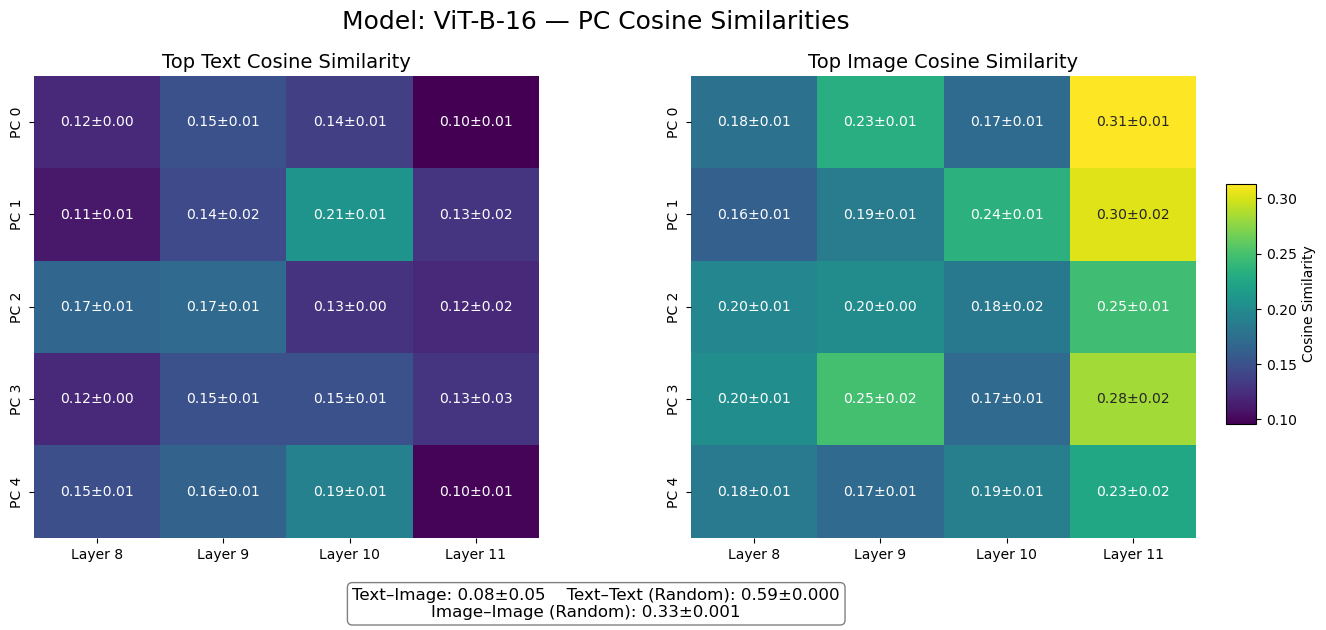

In [85]:
visualize_pc_cosine_similarity(data, final_embeddings_images, final_embeddings_texts, nr_layers_ - 1, model_name = model_name, max_pc = 5)

In [86]:
plot_pc_sv_across_heads_and_layers(data, nr_layers_-1)


=== PC vs. (Text,Image) Cosine Similarities (mean ± std across heads) ===
+------+----------------+---------------+---------------+--------------+----------------+---------------+---------------+--------------+---------------+--------------+--------------+-------------+---------------+--------------+--------------+-------------+
|   PC |   L11_TextMean |   L11_TextStd |   L11_ImgMean |   L11_ImgStd |   L10_TextMean |   L10_TextStd |   L10_ImgMean |   L10_ImgStd |   L9_TextMean |   L9_TextStd |   L9_ImgMean |   L9_ImgStd |   L8_TextMean |   L8_TextStd |   L8_ImgMean |   L8_ImgStd |
|------+----------------+---------------+---------------+--------------+----------------+---------------+---------------+--------------+---------------+--------------+--------------+-------------+---------------+--------------+--------------+-------------|
|    0 |    -0.00889425 |    0.0270462  |   -0.0169054  |    0.0685882 |     0.00512918 |     0.0140886 |    0.00802434 |    0.0317193 |   0.00482648  |  

(   PC  L11_TextMean  L11_TextStd  L11_ImgMean  L11_ImgStd  L10_TextMean  \
 0   0     -0.008894     0.027046    -0.016905    0.068588      0.005129   
 1   1      0.005707     0.020275     0.015362    0.060572      0.008540   
 2   2     -0.006633     0.031682    -0.005934    0.050423      0.004133   
 3   3      0.001123     0.009353     0.006786    0.020571      0.002814   
 4   4      0.001812     0.020909    -0.009861    0.050035     -0.005079   
 
    L10_TextStd  L10_ImgMean  L10_ImgStd  L9_TextMean  L9_TextStd  L9_ImgMean  \
 0     0.014089     0.008024    0.031719     0.004826    0.011371   -0.001733   
 1     0.027661     0.010541    0.035851     0.000221    0.013074   -0.003264   
 2     0.015601     0.001241    0.035149    -0.003224    0.015682   -0.027264   
 3     0.016939     0.012743    0.036433     0.000211    0.019844    0.005692   
 4     0.023755    -0.007759    0.041701     0.006496    0.027655   -0.004810   
 
    L9_ImgStd  L8_TextMean  L8_TextStd  L8_ImgMean  L8

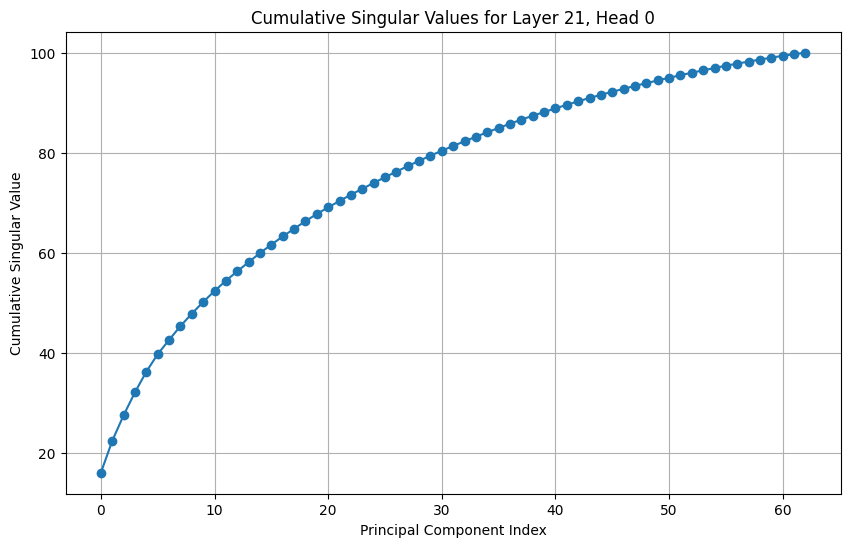

In [35]:
# Visualize PCs strength
data = get_data(attention_dataset)
plot_pc_sv(data, layer, head)

# Query a topic or image and NNs on that

### Define the query and analyze each Principal Component and derive a strength metric for reconstruction of the query-embedding

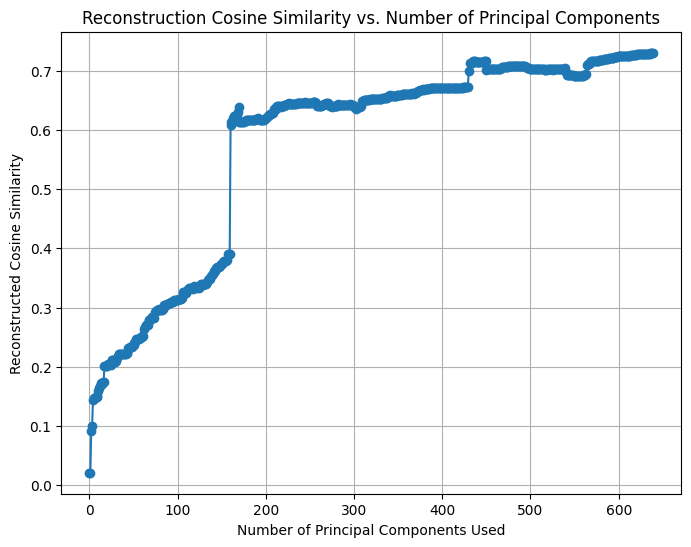

We have a max cosine similarity of: 0.7306


In [8]:
# Set the model to evaluation mode so that no gradients are computed
model.eval()
query_text = True
max_pcs_per_head = 10

# Retrieve an embedding
with torch.no_grad():
    if query_text:
        # If querying by text, define a text prompt and encode it into an embedding
        text_query = "An image of colour black."
        # Tokenize the text query and move it to the device (GPU/CPU)
        text_query_token = tokenizer(text_query).to(device)  
        # Encode the tokenized text into a normalized embedding
        topic_emb = model.encode_text(text_query_token, normalize=True).to(dtype=torch.float32)
    else:
        # If querying by image, load and preprocess the image from disk
        prs.reinit()  # Reinitialize any hooks if required
        text_query = "woman.png"
        image_pil = Image.open(f'images/{text_query}')
        image = preprocess(image_pil)[np.newaxis, :, :, :]  # Add batch dimension
        if precision == "fp16":
            image.to(dtype=torch.float16)
        # Encode the image into a normalized embedding
        topic_emb = model.encode_image(
            image.to(device), 
            attn_method='head_no_spatial',
            normalize=True
        ).to(dtype=torch.float32)

### Reconstruct embedding and find contributions from principal components
# Retrieve data
data = get_data(attention_dataset, max_pcs_per_head, skip_final=True)

# Get mean of data and texts
mean_final_images = torch.mean(final_embeddings_images, axis=0).to(device)
mean_final_texts = torch.mean(final_embeddings_texts, axis=0).to(device)

# Mean center the embeddings
mean_final = mean_final_texts if query_text else mean_final_images

# Mean center the embeddings
topic_emb_cent = topic_emb - mean_final
final_embeddings_texts_cent = final_embeddings_texts.to(device) - mean_final_texts
# Recontruct embedding
[topic_emb_rec_cent], data = reconstruct_embeddings(data, [topic_emb_cent], ["text" if query_text else "image"], return_princ_comp=True, plot=True, means=[mean_final], device=device)

# Normalize the embeddings
topic_emb_rec_cent_norm = topic_emb_rec_cent / topic_emb_rec_cent.norm(dim=-1, keepdim=True)

# The maximum reconstruction score is how close the reconstructed embedding is to the original,
# adjusted by the baseline score. This gives a cosine similarity measure.
topic_emb_cent_norm = topic_emb_cent / topic_emb_cent.norm(dim=-1, keepdim=True)
max_reconstr_score = topic_emb_rec_cent_norm @ topic_emb_cent_norm.T
# Print out the cosine similarity between the original and reconstructed embeddings
print(f"We have a max cosine similarity of: {(max_reconstr_score).item():.4f}")


### Use the strength of the previous reconstruction to derive a good enough reconstruction of the query

Reconstruction Quality Report:
- Maximum achievable reconstruction score: 0.7306
- Used a total number of 17 different heads
- Current reconstruction score: 0.6376
  This corresponds to 87.28% of the maximum possible score.

The reconstruction was performed using the top 30 principal component(s).
 Increasing this number may improve the reconstruction score.




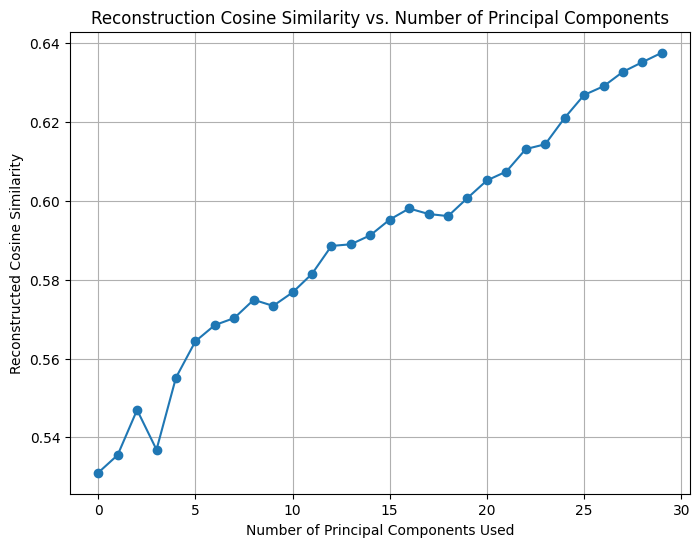

Currently querying the topic: An image of colour black.
Layer 21, Head 0, Principal Component 0, Variance 1.423, Relative Variance 5.635, Head Rank 63
Correlation of the Topic with the Principal Component -0.4275
+----+-------------------------------------------------------+---------------------+-----------------------------------------------------+---------------------+
|    | Negative                                              |   Negative_Strength | Positive                                            |   Positive_Strength |
|----+-------------------------------------------------------+---------------------+-----------------------------------------------------+---------------------|
|  0 | An image of a gathering with people dressed in black. |           -0.421683 | An image of a bride in a white dress.               |            0.149864 |
|  1 | An image of a black animal.                           |           -0.405296 | An image of a white and tan animal.                 |     

In [15]:
# Extract relevant details from the top-k principal component entries based on the reconstruction of the query
top_k = 30 # Maximum number of top entries to retrieve
approx = 1.1  # Target approximation threshold for the reconstruction quality

# Initialize a tensor to accumulate the reconstructed topic embedding from selected principal components
topic_emb_rec_act = torch.zeros_like(topic_emb)

### Extract relevant details from the top k entries
data = sort_data_by(data, "correlation_princ_comp_abs", descending=True) 

top_k_entries = top_data(data, top_k)

top_k_details = reconstruct_top_embedding(top_k_entries, topic_emb_cent, mean_final, "text" if query_text else "image", max_reconstr_score, top_k, approx, device=device)
# Convert the collected principal component details into a DataFrame for easy processing
print(f"Currently querying the topic: {text_query}")
print_data(top_k_details, is_corr_present=True)

### Prepare scores of images and texts 

In [16]:
## For Reconstructed Embedding
# Visualize ds
# Initialize arrays to store the top and lowest scores based on similarity with original query
scores_array_images = np.empty(
    final_embeddings_images.shape[0], 
    dtype=[('score', 'f4'), ('score_vis', 'f4'), ('img_index', 'i4')]
)

# Initialize arrays to store the top and lowest scores based on similarity with self reconstructed query
scores_array_images_self = np.empty(
    final_embeddings_images.shape[0], 
    dtype=[('score', 'f4'), ('score_vis', 'f4'), ('img_index', 'i4')]
)

# Create arrays of indexes for referencing images and texts.
indexes_images = np.arange(0, final_embeddings_images.shape[0], 1) 

# Get mean of data and texts
mean_final_images = torch.mean(final_embeddings_images, axis=0).to(device)


# Recontruct embedding
images_rec = reconstruct_all_embeddings_mean_ablation_pcs(top_k_entries, mlps_, attns_, attns_, nr_layers_, nr_heads_, last_, ratio=-1, ablation=True, mean_ablate_all=True).to(device)


# Compute the similarity scores between the reconstructed embeddings (images or texts) and the original query embedding.
# The dot product gives a similarity measure, which we store in the scores arrays along with the index.
# We do NOT normalize the score.
# Compute scores for images

scores_array_images["score"] = (images_rec @ topic_emb.T).squeeze().cpu().numpy()
scores_array_images_self["score"] = (torch.diag(images_rec @ final_embeddings_images.T)).squeeze().cpu().numpy()

images_rec /= images_rec.norm(dim=-1, keepdim=True)

scores_array_images["score_vis"] = (images_rec @ topic_emb.T).squeeze().cpu().numpy()
scores_array_images_self["score_vis"] = (torch.diag(images_rec @ final_embeddings_images.T)).squeeze().cpu().numpy()

scores_array_images["img_index"] = indexes_images
scores_array_images_self["img_index"] = indexes_images

Heads to keep:  17


In [6]:
# For full CLIP Embedding
# Scores array of real CLIP embeddings
scores_array_images_full = np.empty(
    final_embeddings_images.shape[0], 
    dtype=[('score', 'f4'), ('score_vis', 'f4'), ('img_index', 'i4')]
)

# Compute scores for images
images = final_embeddings_images.to(device)
scores_array_images_full["score"] = (images @ topic_emb.T).squeeze().cpu().numpy()

images /= images.norm(dim=-1, keepdim=True)
scores_array_images_full["score_vis"] = (images @ topic_emb.T).squeeze().cpu().numpy()

scores_array_images_full["img_index"] = indexes_images

# Define the number of top and worst images to look at for each princ_comp
nr_top_imgs = 20  # Number of top elements
nr_worst_imgs = 20  # Number of worst elements
nr_cont_imgs = 20  # Length of continuous elements

NameError: name 'topic_emb' is not defined

### Visualize

----Decomposition for text: 'An image of colour black.'----
Layer 21, Head 0, Principal Component 0, Variance 1.423, Relative Variance 5.635, Head Rank 63
Correlation of the Topic with the Principal Component -0.4275
+----+-------------------------------------------------------+---------------------+-----------------------------------------------------+---------------------+
|    | Negative                                              |   Negative_Strength | Positive                                            |   Positive_Strength |
|----+-------------------------------------------------------+---------------------+-----------------------------------------------------+---------------------|
|  0 | An image of a gathering with people dressed in black. |           -0.421683 | An image of a bride in a white dress.               |            0.149864 |
|  1 | An image of a black animal.                           |           -0.405296 | An image of a white and tan animal.                 | 

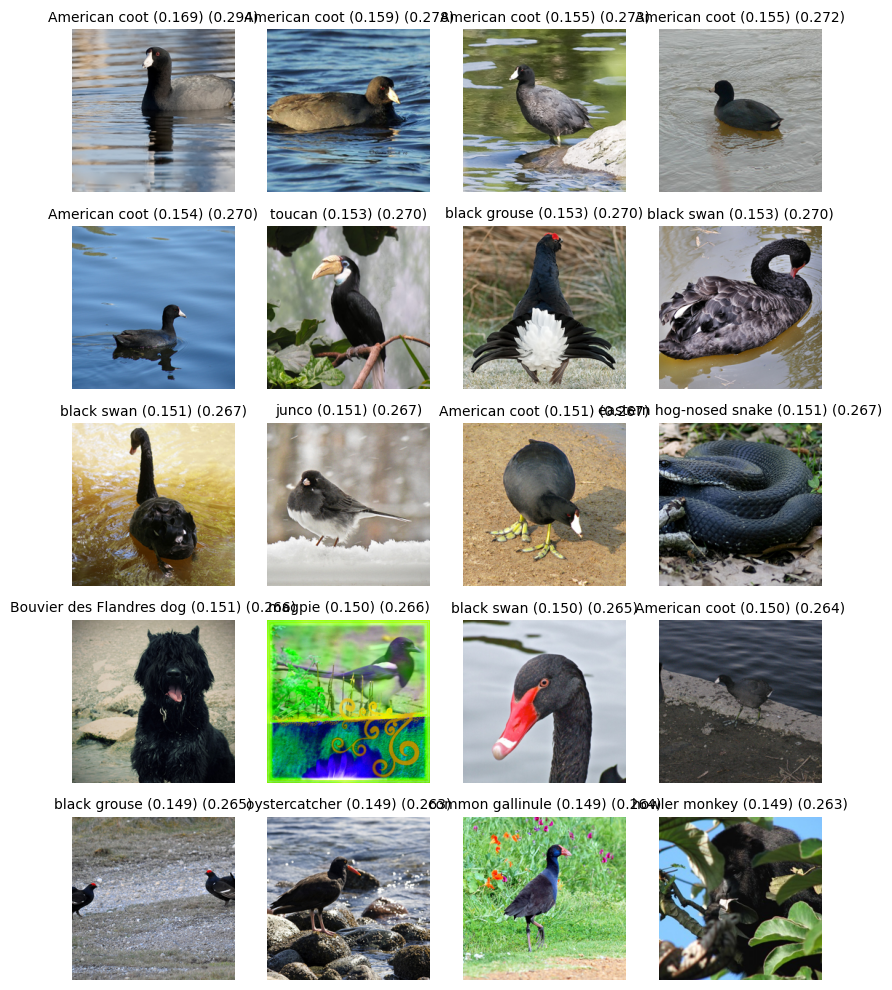

Printing most negative cosine similarity


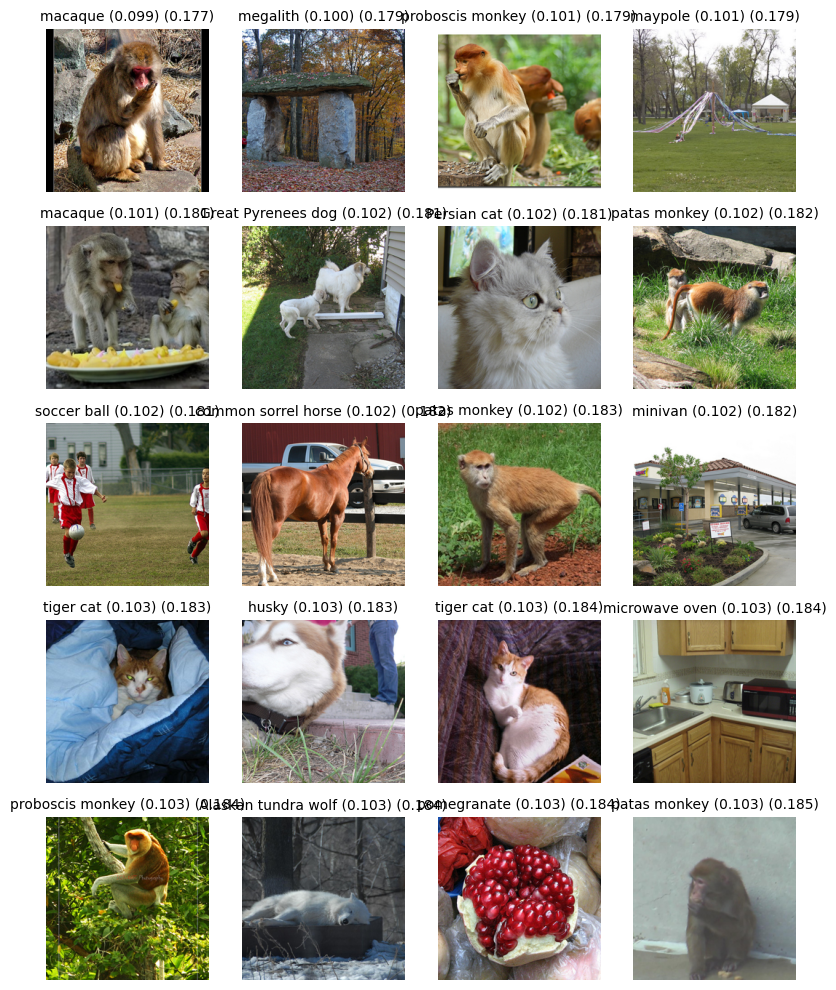

In [18]:
# Define the number of top and worst images to look at for each princ_comp
nr_top_imgs = 20  # Number of top elements
nr_worst_imgs = 20  # Number of worst elements
nr_cont_imgs = 0  # Length of continuous elements

dbs = create_dbs(scores_array_images, None, nr_top_imgs, nr_worst_imgs, nr_cont_imgs)
# Hardcoded visualizations
nrs_dbs = [nr_top_imgs, nr_worst_imgs, nr_cont_imgs]
dbs_new = []
for i, db in enumerate(dbs):
    if nrs_dbs[i] == 0:
        continue
    dbs_new.append(db)
visualize_dbs(top_k_details, dbs_new, ds_vis_, texts_str, classes_, text_query)

----Decomposition for text: 'An image of colour black.'----
Layer 21, Head 0, Principal Component 0, Variance 1.423, Relative Variance 5.635, Head Rank 63
Correlation of the Topic with the Principal Component -0.4275
+----+-------------------------------------------------------+---------------------+-----------------------------------------------------+---------------------+
|    | Negative                                              |   Negative_Strength | Positive                                            |   Positive_Strength |
|----+-------------------------------------------------------+---------------------+-----------------------------------------------------+---------------------|
|  0 | An image of a gathering with people dressed in black. |           -0.421683 | An image of a bride in a white dress.               |            0.149864 |
|  1 | An image of a black animal.                           |           -0.405296 | An image of a white and tan animal.                 | 

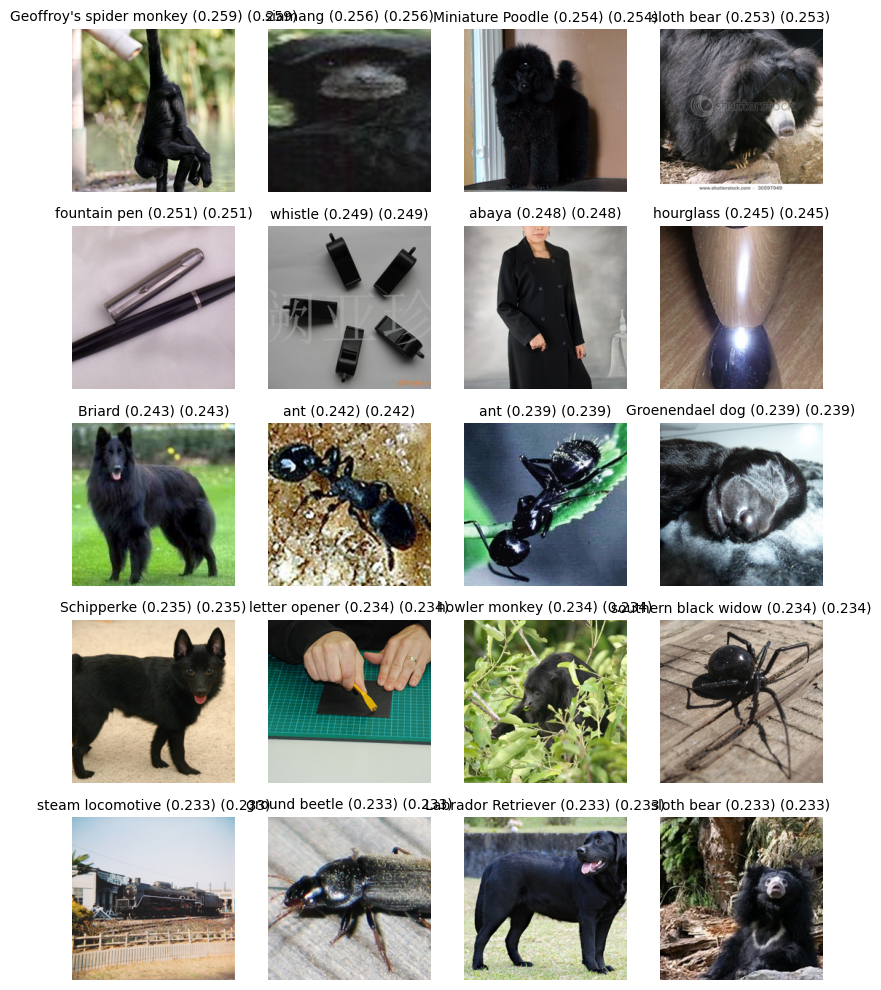

Printing most negative cosine similarity


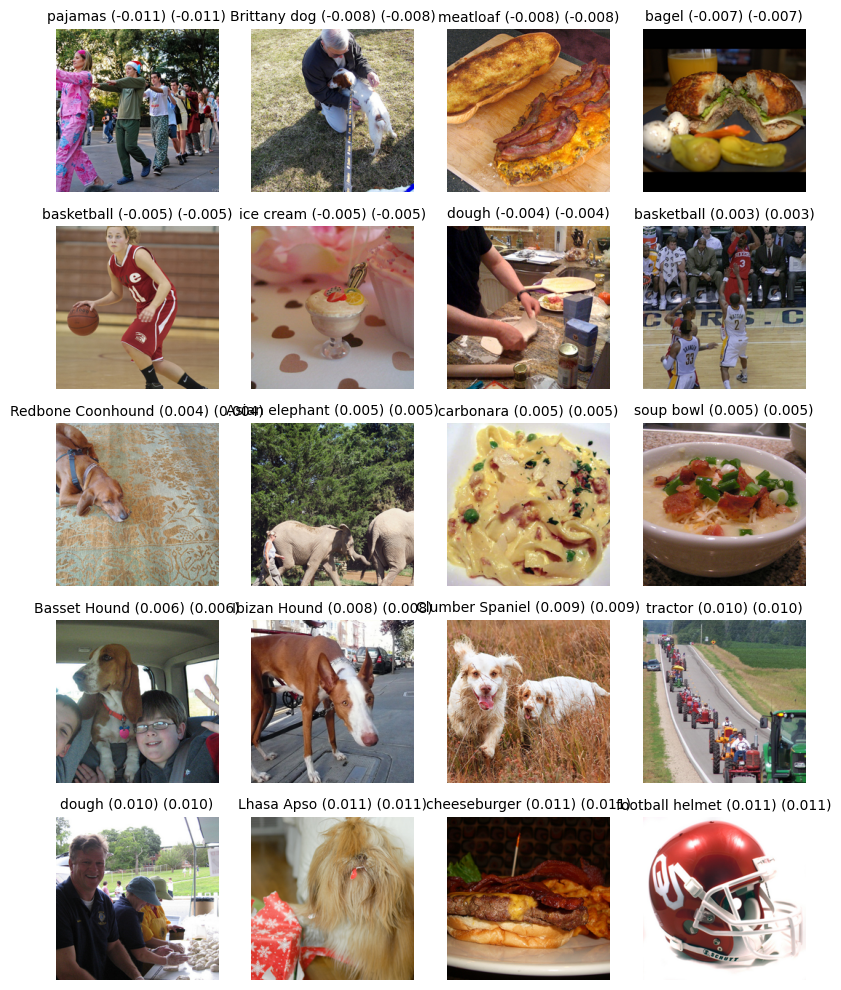

In [19]:
# Visualize full Embeddings similarity
dbs = create_dbs(scores_array_images_full, None, nr_top_imgs, nr_worst_imgs, nr_cont_imgs)
dbs_new = []
for i, db in enumerate(dbs):
    if nrs_dbs[i] == 0:
        continue
    dbs_new.append(db)
visualize_dbs(top_k_details, dbs_new, ds_vis_, texts_str, classes_, text_query)

In [ ]:
# Define the number of top and worst images to look at for each princ_comp
dbs = create_dbs(scores_array_images_self, None, nr_top_imgs, nr_worst_imgs, nr_cont_imgs)
dbs_new = []
for i, db in enumerate(dbs):
    if nrs_dbs[i] == 0:
        continue
    dbs_new.append(db)
visualize_dbs(top_k_details, dbs_new, ds_vis_, texts_str, classes_, text_query)

### Opt, visualize using all NOT selected PCs 

In [ ]:
# Get other PCs
data = get_data(attention_dataset, -1, skip_final=True)

top_k_other_details = get_remaining_pcs(data, top_k_entries)

# Recontruct embedding

images_rec = reconstruct_all_embeddings_mean_ablation_pcs(top_k_other_details, mlps_, attns_, attns_, nr_layers_, nr_heads_, last_, ratio=-1, mean_ablate_all=True)

# Compute the similarity scores between the reconstructed embeddings (images or texts) and the original query embedding.
# The dot product gives a similarity measure, which we store in the scores arrays along with the index.
# We do NOT normalize the score.
# Compute scores for images

scores_array_images["score"] = (images_rec @ topic_emb.T).squeeze().cpu().numpy()
scores_array_images_self["score"] = (torch.diag(images_rec @ final_embeddings_images.T)).squeeze().cpu().numpy()

images_rec /= images_rec.norm(dim=-1, keepdim=True)

scores_array_images["score_vis"] = (images_rec @ topic_emb.T).squeeze().cpu().numpy()
scores_array_images_self["score_vis"] = (torch.diag(images_rec @ final_embeddings_images.T)).squeeze().cpu().numpy()

scores_array_images["img_index"] = indexes_images
scores_array_images_self["img_index"] = indexes_images


In [ ]:
dbs = create_dbs(scores_array_images, None, nr_top_imgs, nr_worst_imgs, nr_cont_imgs)
# Hardcoded visualizations
nrs_dbs = [nr_top_imgs, nr_worst_imgs, nr_cont_imgs]
dbs_new = []
for i, db in enumerate(dbs):
    if nrs_dbs[i] == 0:
        continue
    dbs_new.append(db)
visualize_dbs(top_k_details, dbs_new, ds_vis_, texts_str, classes_, text_query)

In [ ]:
# Define the number of top and worst images to look at for each princ_comp
dbs = create_dbs(scores_array_images_self, None, nr_top_imgs, nr_worst_imgs, nr_cont_imgs)
dbs_new = []
for i, db in enumerate(dbs):
    if nrs_dbs[i] == 0:
        continue
    dbs_new.append(db)
visualize_dbs(top_k_details, dbs_new, ds_vis_, texts_str, classes_, text_query)

# Evaluate classification using reconstruction

## Ablation Study

In [ ]:
nr_layers = attns_.shape[1]
# Evaluate accuracy using the reconstructed embeddings from the final embedding approach
accs = []
for layer_nr in range(nr_layers):
    current_mean_ablation_per_head_sum = torch.mean(no_heads_attentions_[:, :layer_nr], axis=0).sum(0)
    current_model = (current_mean_ablation_per_head_sum  + no_heads_attentions_[:, layer_nr + 1:].sum(1)) + mlps_.sum(axis=1) 
    acc, _ = test_accuracy(current_model @ classifier_, labels_, label=f"Mean ablation from layer {nr_layers - layer_nr} to {nr_layers}")
    accs.append(acc)

# Create an x-axis that has one increment for each element in acc
x_values = range(len(accs))

# Plot
plt.figure(figsize=(8, 5))
plt.plot(x_values, accs, linestyle='-', label=model_name)

# Labeling
plt.xlabel("Accumulated mean-ablated layers")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Accumulated Mean-Ablated Layers")

# Add legend for the line
plt.legend()

plt.grid(True)
plt.show()

## Proof of concept 1: Use aggregations of PCs of all labels at once

In [ ]:
pcs_per_class_start = 1
pcs_per_class_end = int(nr_heads_*num_last_layers_*mean_rank_)
pcs_per_class_step = 10
max_pcs_per_head = -1
random = False

proof_concept_1_pcs_all(classifier_, attns_, mlps_, labels_, classes_, model_name, background_groups_, final_embeddings_texts, attention_dataset, nr_layers_, nr_heads_, num_last_layers_, pcs_per_class_start=pcs_per_class_start, pcs_per_class_end=pcs_per_class_end, pcs_per_class_step=pcs_per_class_step, max_pcs_per_head=max_pcs_per_head, random=random)


## Proof of concept 2: Remove concepts from the model and use other PCs to reconstruct

In [ ]:
pcs_per_class_start = 1
pcs_per_class_end = int(nr_heads_*num_last_layers_*mean_rank_)
pcs_per_class_step = 10
max_pcs_per_head = -1
random = False
concepts_to_remove = ["An image of water", "An image of land"]


proof_concept_2_remove(classifier_, attns_, mlps_, labels_, classes_, model_name, model, tokenizer, device, background_groups_, final_embeddings_texts, attention_dataset, nr_layers_, nr_heads_, num_last_layers_, concepts_to_remove = concepts_to_remove, pcs_per_class_start=pcs_per_class_start, pcs_per_class_end=pcs_per_class_end, pcs_per_class_step=pcs_per_class_step, max_pcs_per_head=max_pcs_per_head, random=random)


## Proof of concept 3: Use as main components of the model what we want

In [ ]:
pcs_per_class_start = 1
pcs_per_class_end = int(nr_heads_*num_last_layers_*mean_rank_)
pcs_per_class_step = 10
max_pcs_per_head = -1
random = False
concepts_to_add = ["Airplane: Rigid wings with visible engines, designed for powered flight across the sky.",
    "Automobile: An enclosed passenger cabin on four wheels, merging front and back into a single body.",
    "Bird: Vibrant feathers and a beak, gliding or flapping through the air with living wings.",
    "Cat: Soft fur and vertical slit pupils, stepping gracefully on paws with retractable claws.",
    "Deer: Antlers crown the head in many males, paired with nimble legs for bounding movement.",
    "Dog: Visible, non-retractable claws, a wagging tail, and an eager stance for active play.",
    "Frog: Smooth, moist amphibian skin and strong hind legs, poised for agile leaps on land or water.",
    "Horse: A flowing mane along a powerful neck, galloping on solid hooves with spirited energy.",
    "Ship: A buoyant hull carrying cargo or passengers, traversing vast waters under open skies.",
    "Truck: A strong cab up front and a distinct cargo bed behind, hauling heavy loads with ease."
]


proof_concept_3_add(classifier_, attns_, mlps_, labels_, classes_, model_name, model, tokenizer, device, background_groups_, final_embeddings_texts, attention_dataset, nr_layers_, nr_heads_, num_last_layers_, concepts_to_add = concepts_to_add, pcs_per_class_start=pcs_per_class_start, pcs_per_class_end=pcs_per_class_end, pcs_per_class_step=pcs_per_class_step, max_pcs_per_head=max_pcs_per_head, random=random)

## Proof of concept 4: Compare cosine of reconstruction using PCs of one class vs. all classes

In [ ]:
pcs_per_class_start = 1
pcs_per_class_end = int(nr_heads_*num_last_layers_*mean_rank_)
pcs_per_class_step = 10
max_pcs_per_head = -1
random = False

proof_concept_4_pcs_single(classifier_, attns_, mlps_, labels_, classes_, model_name, background_groups_, final_embeddings_texts, final_embeddings_images, subset_dim, attention_dataset, nr_layers_, nr_heads_, num_last_layers_, pcs_per_class_start=pcs_per_class_start, pcs_per_class_end=pcs_per_class_end, pcs_per_class_step=pcs_per_class_step, max_pcs_per_head=max_pcs_per_head, random=random)

## Comparison Textspan with waterbird

In [ ]:
# Retrive heads textspan
if model_name == "ViT-H-14":
    to_mean_ablate_setting = [
        {"layer": 31, "head": 12},
        {"layer": 30, "head": 11},
        {"layer": 29, "head": 4},
    ]
    to_mean_ablate_geo = [
        {"layer": 31, "head": 8},
        {"layer": 30, "head": 15},
        {"layer": 30, "head": 12},
        {"layer": 30, "head": 6},
        {"layer": 29, "head": 14},
        {"layer": 29, "head": 8},
    ]

elif model_name == "ViT-L-14":
    to_mean_ablate_geo = [
        {"layer": 21, "head": 1},
        {"layer": 22, "head": 12},
        {"layer": 22, "head": 13},
        {"layer": 21, "head": 11},
        {"layer": 21, "head": 14},
        {"layer": 23, "head": 6},
    ]
    to_mean_ablate_setting = [
        {"layer": 21, "head": 3},
        {"layer": 21, "head": 6},
        {"layer": 21, "head": 8},
        {"layer": 21, "head": 13},
        {"layer": 22, "head": 2},
        {"layer": 22, "head": 12},
        {"layer": 22, "head": 15},
        {"layer": 23, "head": 1},
        {"layer": 23, "head": 3},
        {"layer": 23, "head": 5},
    ]

elif model_name == "ViT-B-16":
    to_mean_ablate_setting = [
        {"layer": 11, "head": 3},
        {"layer": 10, "head": 11},
        {"layer": 10, "head": 10},
        {"layer": 9, "head": 8},
        {"layer": 9, "head": 6},
    ]
    to_mean_ablate_geo = [
        {"layer": 11, "head": 6},
        {"layer": 11, "head": 0},
    ]

elif model_name == "ViT-B-32":
    to_mean_ablate_setting = [
        {"layer": 11, "head":5},
        {"layer": 10, "head": 5},
        {"layer": 10, "head": 3},
        {"layer": 9, "head": 1},
    ]
    to_mean_ablate_geo = [
        {"layer": 11, "head": 9},
        {"layer": 11, "head": 5},
    ]
to_mean_ablate_geo_heads = to_mean_ablate_setting + to_mean_ablate_geo
all_heads = [{"layer": l, "head": h} for l in range(nr_layers_ - num_last_layers_, nr_layers_) for h in range(nr_heads_)]
for h_1 in to_mean_ablate_geo_heads:
    for c, h_2 in enumerate(all_heads):
        if h_1 == h_2:
            all_heads = all_heads[:c] + all_heads[c+1:]
            break

reconstructed_images = reconstruct_all_embeddings_mean_ablation_heads(all_heads, mlps_, attns_, final_embeddings_images,nr_layers_, nr_heads_, num_last_layers_)
reconstructed_images /= reconstructed_images.norm(dim=-1, keepdim=True)
predictions = reconstructed_images @ classifier_ #class_embeddings[text_idx, :].T

# Optionally, check accuracy for the current text_idx predictions
acc, idxs = test_accuracy(predictions, labels_, label=f"Textspan")
print_correct_elements(idxs, labels_, classes_)    
if classes_ == waterbird_classes:
    test_waterbird_preds(idxs, labels_, background_groups_)



## Test different accuracies

In [ ]:
# Print shapes of the tensors for debugging purposes:
# attns_: attention activations
# mlps_: MLP activations
# classifier_: classifier weights
# labels_: ground truth labels
print(attns_.shape, mlps_.shape, classifier_.shape, labels_.shape)


# Baseline accuracy computation:
baseline = attns_.sum(axis=(1, 2)) + mlps_.sum(axis=1)
test_accuracy(baseline.to(dtype=torch.float32) @ classifier_.to(dtype=torch.float32), labels_, label="Baseline")
mean_final_images = torch.mean(final_embeddings_images, axis=0)
mean_final_texts = torch.mean(final_embeddings_texts, axis=0)

# Test accuracy of mean centered data with mean centered text
mean_centered_data = attns_.sum(axis=(1, 2)) + mlps_.sum(axis=1) - mean_final_images
mean_centered_data /= mean_centered_data.norm(dim=-1, keepdim=True)
mean_centered_classifier_ = classifier_ - mean_final_texts.unsqueeze(-1)
mean_centered_classifier_ /= mean_centered_classifier_.norm(dim=-1, keepdim=True)

test_accuracy(mean_centered_data @ mean_centered_classifier_, labels_, label="Mean centered data with mean centered text")

# Test accuracy of mean centered data with original text
mean_centered_data = attns_.sum(axis=(1, 2)) + mlps_.sum(axis=1) - mean_final_images
mean_centered_data /= mean_centered_data.norm(dim=-1, keepdim=True)
mean_centered_data += mean_final_images
mean_centered_data /= mean_centered_data.norm(dim=-1, keepdim=True)
test_accuracy(mean_centered_data @ classifier_, labels_, label="Mean centered data with original (not mean centered) text")

# We now attempt a "mean ablation" approach for attention
current_model = (current_mean_ablation_per_head_sum_
                 + no_heads_attentions_[:, last_ + 1:].sum(1)) + mlps_.sum(axis=1) 
_, indexes_mean_ablate = test_accuracy(current_model @ classifier_, labels_, label=f"Mean ablation from layer {last_} until layer {attns_.shape[1]}")

# We now attempt a "mean ablation" approach for attention
current_model = (current_mean_ablation_per_head_sum_
                 + no_heads_attentions_[:, last_ + 1:].sum(1)) + mlps_.sum(axis=1) 
current_model -= mean_final_images
current_model /= current_model.norm(dim=-1, keepdim=True)
_, indexes_mean_ablate = test_accuracy(current_model @ classifier_, labels_, label=f"Mean ablation from layer {last_} until layer {attns_.shape[1]} with mean centered images")

# Test accuracy of data with mean centered text on mean of data
mean_centered_data = attns_.sum(axis=(1, 2)) + mlps_.sum(axis=1)


mean_centered_classifier_ = classifier_ - mean_final_texts.unsqueeze(-1) + mean_final_images.unsqueeze(-1)

test_accuracy(mean_centered_data @ mean_centered_classifier_, labels_, label="Data with mean centered text on data")


## Test different accuracies using reconstructions

In [ ]:
final_embeddings_images_rec_embed = torch.zeros_like(final_embeddings_images)
final_embeddings_images_rec_attns = torch.zeros_like(final_embeddings_images)
final_embeddings_images_rec_attns_not_mean_centered = torch.zeros_like(final_embeddings_images)
image_emb_cent_embed = final_embeddings_images - mean_final_images

final_embeddings_texts_rec_embed = torch.zeros_like(classifier_.T)
texts_emb_cent_embed = (classifier_ - mean_final_texts.unsqueeze(-1)).T

# Open the attention dataset to retrieve projection matrices and mean values
with open(attention_dataset, "r") as json_file:
    for line in json_file:
        entry = json.loads(line)
        # If this entry is the final embedding entry (head == -1), skip it.
        if entry["head"] == -1:
            last_line = entry
            continue

        project_matrix = torch.tensor(entry["project_matrix"])
        vh = torch.tensor(entry["vh"])
        # Reconstruct the image embeddings using final embeddings:
        # Center them by subtracting mean attention values, project them through vh, 
        # apply project_matrix and vh again, then add mean values back.
        final_embeddings_images_rec_embed += (image_emb_cent_embed) @ vh.T @ project_matrix @ vh
        final_embeddings_texts_rec_embed += (texts_emb_cent_embed) @ vh.T @ project_matrix @ vh
        # Reconstruct the image embeddings using attention activations:
        # Similar process, but start from attns_ for the given layer/head.
        image_emb_cent_attns = attns_[:, entry["layer"], entry["head"], :] - torch.tensor(entry["mean_values_att"])
        final_embeddings_images_rec_attns += (image_emb_cent_attns) @ vh.T @ project_matrix @ vh + torch.tensor(entry["mean_values_att"])
        final_embeddings_images_rec_attns_not_mean_centered += (image_emb_cent_attns) @ vh.T @ project_matrix @ vh

final_embeddings_images_rec_embed_norm = final_embeddings_images_rec_embed/final_embeddings_images_rec_embed.norm(dim=-1, keepdim=True)

final_embeddings_texts_rec_embed_norm = final_embeddings_texts_rec_embed/final_embeddings_texts_rec_embed.norm(dim=-1, keepdim=True)

final_embeddings_images_rec_attns_not_mean_centered_norm = final_embeddings_images_rec_attns_not_mean_centered/final_embeddings_images_rec_attns_not_mean_centered.norm(dim=-1, keepdim=True)

texts_emb_cent_embed /= texts_emb_cent_embed.norm(dim=-1, keepdim=True)
# Evaluate accuracy using the reconstructed embeddings from the final embedding approach
current_model = final_embeddings_images_rec_embed_norm + mean_final_images
_, indexes_approx_final = test_accuracy(current_model @ classifier_, labels_, label=f"Approximation with final embeddings on only the last layers")

current_model = mlps_.sum(axis=1) + current_mean_ablation_per_head_sum_ + final_embeddings_images_rec_attns_not_mean_centered
_, indexes_approx_activ_only = test_accuracy(current_model @ classifier_, labels_, label=f"Approximation of images with direct contribution of activation space")

# Evaluate accuracy using the reconstructed embeddings from the attention activations approach
current_model = (mlps_.sum(axis=1) + current_mean_ablation_per_head_sum_ + final_embeddings_images_rec_attns)
_, indexes_approx_activ = test_accuracy(current_model @ classifier_, labels_, label=f"Approximation with attention activations")


# Evaluate accuracy using the reconstructed embeddings from the final embedding approach
current_model = final_embeddings_images_rec_embed+ mean_final_images
_, indexes_approx_final = test_accuracy(current_model @ classifier_, labels_, label=f"Approximation of images without mean-ablation")


# Evaluate accuracy using the reconstructed embeddings from the final embedding approach
current_model = final_embeddings_images_rec_embed+ mean_final_images
_, indexes_approx_final = test_accuracy(current_model @ classifier_, labels_, label=f"Approximation of images and texts without mean-ablation")

# Evaluate accuracy using the reconstructed embeddings from the final embedding approach
current_model = (mlps_.sum(axis=1) + current_mean_ablation_per_head_sum_ + final_embeddings_images_rec_attns)
_, indexes_approx_final = test_accuracy(current_model @ classifier_, labels_, label=f"Original images and approximation of texts without mean-ablation")


## Test Bias Correction

In [ ]:
cache_dir = "../cache"
top_k = 30  # Maximum number of top entries to retrieve
approx = 1.1  # Target approximation threshold for the reconstruction quality
## Run the chosen algorithm on a dataset to derive text explanations 
command = f"python -m utils.scripts.bias_removal_test \
    --device {device} --model {model_name} --pretrained {pretrained} --seed {seed} \
    --subset_dim {subset_dim} --dataset_text {dataset_text_name} --dataset {datataset_image_name} \
    --device {device} --top_k {top_k} --max_approx {approx} --cache_dir {cache_dir}"
!{command}

## Test bias removal and subset model

In [ ]:
# Next, we calculate scores for each principal component (PC) while ignoring query info.
# We do this by reconstructing embeddings from the principal components alone, both from 
# the final embeddings perspective and the attention activations perspective.

final_embeddings_images_rec_embed_topic = torch.zeros_like(final_embeddings_images)
final_embeddings_images_rec_attns_topic = torch.zeros_like(final_embeddings_images)

image_emb_cent_embed = final_embeddings_images - mean_final_images

top_k_other_details = get_remaining_pcs(data, top_k_details)

# Iterate through the top_k entries and reconstruct embeddings
for entry in top_k_details:
    # Reconstruct embeddings focusing on each principal component:
    # 1. Start from the final embeddings, center them, and extract the component of interest.
    vh = torch.tensor(entry["vh"])
    project_matrix = torch.tensor(entry["project_matrix"])
    princ_comp = torch.tensor(entry["princ_comp"])

    projection_image_embed = image_emb_cent_embed @ vh.T
    mask_images_embed = torch.zeros_like(projection_image_embed)
    mask_images_embed[:, princ_comp] = projection_image_embed[:, princ_comp]
    final_embeddings_images_rec_embed_topic += mask_images_embed @ project_matrix @ vh

    # Repeat for attention-based activations:
    mean_values_att = torch.tensor(entry["mean_values_att"])
    image_emb_cent_attns = attns_[:, entry["layer"], entry["head"], :] - mean_values_att
    projection_images_attns = image_emb_cent_attns @ vh.T
    mask_images_attns = torch.zeros_like(projection_images_attns)
    mask_images_attns[:, princ_comp] = projection_images_attns[:, princ_comp]
    final_embeddings_images_rec_attns_topic += mask_images_attns @ project_matrix @ vh


# Compute accuracy using the reconstruction from final embeddings, ignoring the query information.
current_model = final_embeddings_images_rec_embed - final_embeddings_images_rec_embed_topic
_, indexes_approx_final_rem = test_accuracy(current_model @ texts_emb_cent_embed.T, labels_, label=f"Approximation with current topic final embeddings (Bias removal)")
print_diff_elements(indexes_approx_final, indexes_approx_final_rem, subset_dim)

# Compute accuracy using the reconstruction from attention activations, also ignoring the query information.
current_model = final_embeddings_images_rec_attns_not_mean_centered - final_embeddings_images_rec_attns_topic
_, indexs_approx_activ_rem = test_accuracy(current_model @ texts_emb_cent_embed.T, labels_, label=f"Approximation with current topic final embeddings (Bias Removal)")
print_diff_elements(indexes_approx_activ_only, indexs_approx_activ_rem, subset_dim)

# Compute accuracy using the reconstruction from final embeddings, ignoring the query information.
current_model = final_embeddings_images_rec_embed_topic
_, indexes_approx_final_rem = test_accuracy(current_model @ texts_emb_cent_embed.T, labels_, label=f"Approximation with current topic final embeddings (Subset)")
print_correct_elements(indexes_approx_final_rem, labels_, classes_)

# Compute accuracy using the reconstruction from attention activations, also ignoring the query information.
current_model = final_embeddings_images_rec_attns_topic
_, indexs_approx_activ_rem = test_accuracy(current_model @ texts_emb_cent_embed.T, labels_, label=f"Approximation with current topic final embeddings (Subset)")
print_correct_elements(indexs_approx_activ_rem, labels_, classes_)
